# Task 1 Skeleton Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [2]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [3]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [4]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task 1: OvA SVM on iris
We use gradient descent to train 3 SVMs

Original target function: 

$ L(\textbf{w}) = \frac{1}{2} \left \| \textbf{w} \right \|^2 + C \sum_i max(0, 1- y_i \times <\textbf{x}_i, \textbf{w}>) $

The gradient w.r.t $\textbf{w}$ of the target function:

$ L'(\textbf{w})=\frac{d L(\textbf{w})}{d \textbf{w}} = \textbf{w} +C \sum_i \left\{\begin{matrix} -y_i  \textbf{x}_i & \text{, if }  y_i \times < \textbf{x}_i, \textbf{w}> \le 1\\ 
0 & \texttt{, otherwise} 
\end{matrix}\right. $

In [5]:
C=10.0 # the lambda
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [6]:
def L_prime_w(X, Y, w):
    m, n = X.shape
    grad = np.zeros([w.shape[0], w.shape[1]])
    for i in range(m):
        if Y[i]*np.dot(X[i], w) <= 1:
            grad += (-Y[i]*X[i]).reshape(5,1)
    # calculate the gradient
    grad = w + C*grad
    return grad

In [7]:
def L_w(X, Y, w):
    m, n = X.shape
    ret = 0
    for i in range(m):
        if 1-(Y[i]*np.dot(X[i], w)) > 0:
            ret += 1-Y[i]*np.dot(X[i], w)
    ret = 0.5*(np.linalg.norm(w)**2) + C*ret
    
    return ret

In [8]:
#w = np.random.randn(X_train.shape[1], 1)
def train_svm(X_train, Y_train):
    w = np.zeros((X_train.shape[1],1))
    
    for i in range(n_iter):
        gradient = L_prime_w(X_train, Y_train, w)
        w_new = w - (learning_rate*gradient)
        iterations.append(i+1)

        if np.linalg.norm(w_new - w, ord = 1) < 0.001:
            print("gradient descent has converged after " + str(i) + " iterations")
            break
        if i % 1000 == 0:
            print(i, np.linalg.norm(w_new - w, ord = 1))
        w = w_new
    return w

### (Warning! The next cell takes time to finish the descending)

In [9]:
w1 = np.copy(train_svm(X_train, y_train1))
print ("w1 vector:",  w1.tolist())
w2 = np.copy(train_svm(X_train, y_train2))
print ("w2 vector:",  w2.tolist())
w3 = np.copy(train_svm(X_train, y_train3))
print ("w3 vector:",  w3.tolist())

0 0.8824999999999998
gradient descent has converged after 165 iterations
w1 vector: [[0.13706870445168154], [0.22387327285027772], [0.6217347797476844], [-1.0914360336784867], [-0.51157248524306]]
0 0.5651
1000 0.4609553624356504
2000 0.36728835264384024
3000 0.41975014563197854
4000 0.43329862753334714
5000 0.43223791544773627
6000 0.43226824464687863
7000 0.3592903156904593
8000 0.4026155586485771
9000 0.42174010320938327
10000 0.4026564584524035
11000 0.4217745861825237
12000 0.4026896359188892
13000 0.40270111318761326
14000 0.43301172706941754
15000 0.35941377794509227
16000 0.3703171483767201
17000 0.3703169861551151
18000 0.37031689739481044
19000 0.37031726981108254
w2 vector: [[6.391768255010402], [-0.31933682516848694], [-2.2502337671068617], [1.6890043991911978], [-3.304710022048254]]
0 0.3689000000000001
1000 0.01895838433401842
2000 0.0031263054072552254
3000 0.053403942484862243
4000 0.027836688344175187
5000 0.027744036668115424
6000 0.027878118095105764
7000 0.009915442

In [10]:
w= np.concatenate((w1,w2,w3),axis=1)
print ("w.shape:", w.shape)

w.shape: (5, 3)


In [11]:
def eva_accuracy(X_train, y_train, w):
    prediction = 2 * (np.dot(X_train, w) >= 0) - 1
    accuracy = np.sum(prediction == y_train.reshape(-1, 1))*1.0/X_train.shape[0]
    return accuracy
#print(prediction.shape, Y_test.shape)
accuracy1 = eva_accuracy(X_train, y_train1, w1)
print ("training accuracy1: " + str(accuracy1))
accuracy2 = eva_accuracy(X_train, y_train2, w2)
print ("training accuracy2: " + str(accuracy2))
accuracy3 = eva_accuracy(X_train, y_train3, w3)
print ("training accuracy3: " + str(accuracy3))

training accuracy1: 1.0
training accuracy2: 0.775
training accuracy3: 0.9583333333333334


### Results on training set

In [12]:
prediction1 = np.dot(X_train, w1)
prediction2 = np.dot(X_train, w2)
prediction3 = np.dot(X_train, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
print ("Total training accuracy:", total_accuracy*100, "%.")

Total training accuracy: 95.83333333333334 %.


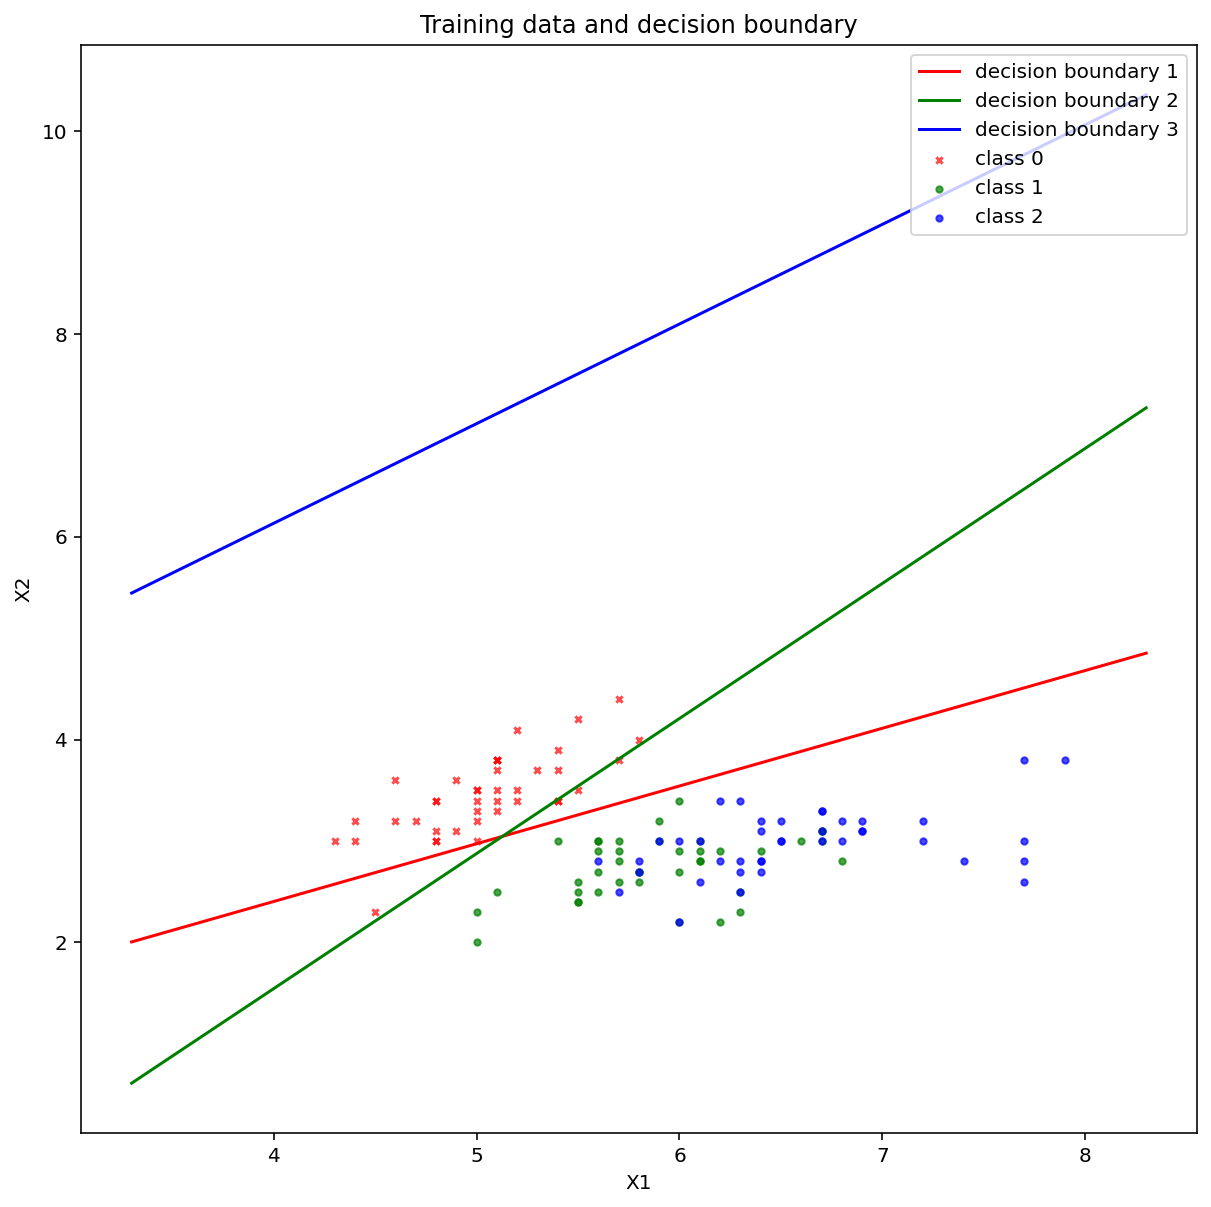

In [13]:
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on test set

In [14]:
prediction1 = np.dot(X_test, w1)
prediction2 = np.dot(X_test, w2)
prediction3 = np.dot(X_test, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
print ("Total test accuracy:", total_accuracy*100, "%.")

Total test accuracy: 100.0 %.
